# Audio-visual emotion recognition

## Libraries

In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import numpy as np

%matplotlib inline

tf.random.set_seed(42)

2024-09-12 17:03:12.382892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 17:03:12.451294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 17:03:12.452571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 17:03:13.534334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading dataset

In [2]:
def unpacking_zip_file(zip_path, dir_to_extract):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir_to_extract)

Zip files with RAVDESS dataset consisting of audio, visual and audio-visual files were downloaded from https://zenodo.org/records/1188976

## Visual data

Since the code was run using Google Cloud Platform, extracted data was uploaded to Google Cloud Storage buckets

In [3]:
from google.cloud import storage

storage_client = storage.Client()

bucket_name = 'audio_visual_data'
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix='data/visual_data')

emotions = []
path_emotions = []

for blob in blobs:
        parts = blob.name.split('/')
        directory = '/'.join(parts[:-1])
        file_name = parts[-1]  # Get only the file name
        # print(directory)
        # print(file_name)
        # print('-'*20)
        if file_name.startswith('02'):
            current_emotion = file_name.split('-')[2]
            emotions.append(int(current_emotion))
            path_emotions.append(os.path.join(directory, file_name))


In [4]:
blobs = bucket.list_blobs(prefix='data/audio_data')

path_emotions_audio = []

for blob in blobs:
        parts = blob.name.split('/')
        if parts[-1] != '':
            directory = '/'.join(parts[:-1])
            file_name = parts[-1]  # Get only the file name
        
        
            path_emotions_audio.append(os.path.join(directory, file_name))

### Pandas dataframe with corresponding paths and labels

In [5]:
emotions_df = pd.DataFrame(emotions, columns=['label'])
path_emotions_df = pd.DataFrame(path_emotions, columns=['path_video'])
path_emotions_audio_df = pd.DataFrame(path_emotions_audio, columns = ['path_audio'])
df = pd.concat([emotions_df, path_emotions_df, path_emotions_audio_df], axis = 1)
df.head()

,label,path_video,path_audio
0,1,data/visual_data/Actor_01/02-01-01-01-01-01-01...,data/audio_data/Actor_01/03-01-01-01-01-01-01.wav
1,1,data/visual_data/Actor_01/02-01-01-01-01-02-01...,data/audio_data/Actor_01/03-01-01-01-01-02-01.wav
2,1,data/visual_data/Actor_01/02-01-01-01-02-01-01...,data/audio_data/Actor_01/03-01-01-01-02-01-01.wav
3,1,data/visual_data/Actor_01/02-01-01-01-02-02-01...,data/audio_data/Actor_01/03-01-01-01-02-02-01.wav
4,2,data/visual_data/Actor_01/02-01-02-01-01-01-01...,data/audio_data/Actor_01/03-01-02-01-01-01-01.wav


In [6]:
emotion_dict = { 1 : 'neutral', 
                 2 : 'calm', 
                 3 : 'happy', 
                 4 : 'sad', 
                 5 : 'angry', 
                 6 : 'fearful', 
                 7 : 'disgust', 
                 8 : 'surprised'}

In [7]:
df['label'] = df['label'].map(emotion_dict)

In [8]:
df.head()

,label,path_video,path_audio
0,neutral,data/visual_data/Actor_01/02-01-01-01-01-01-01...,data/audio_data/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,data/visual_data/Actor_01/02-01-01-01-01-02-01...,data/audio_data/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,data/visual_data/Actor_01/02-01-01-01-02-01-01...,data/audio_data/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,data/visual_data/Actor_01/02-01-01-01-02-02-01...,data/audio_data/Actor_01/03-01-01-01-02-02-01.wav
4,calm,data/visual_data/Actor_01/02-01-02-01-01-01-01...,data/audio_data/Actor_01/03-01-02-01-01-01-01.wav


## EDA (Exploratory data analysis)

In [9]:
df['label'].value_counts()

label
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

In [10]:
df['label']

0         neutral
1         neutral
2         neutral
3         neutral
4            calm
          ...    
1435    surprised
1436    surprised
1437    surprised
1438    surprised
1439    surprised
Name: label, Length: 1440, dtype: object

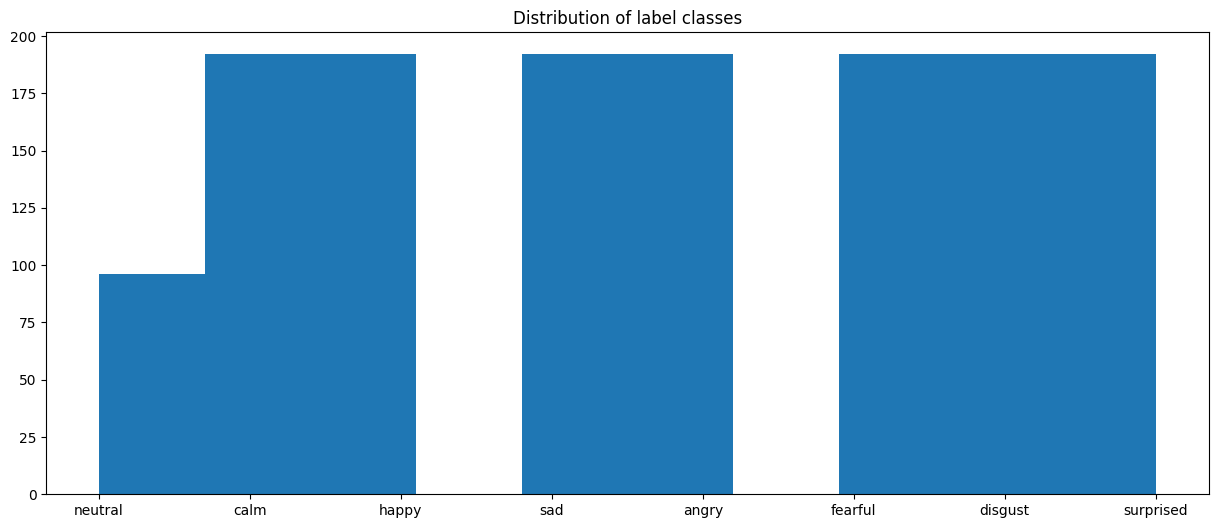

In [11]:
plt.figure(figsize = (15, 6))

plt.hist(df['label'])
plt.title('Distribution of label classes')
plt.show()

In [12]:
import tempfile

def download_video_from_gcs(bucket_name, gcs_video_path): # Function for downloading files from Google Storage
    
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(gcs_video_path)
    
    with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as temp_file:
        blob.download_to_filename(temp_file.name)
        return temp_file.name

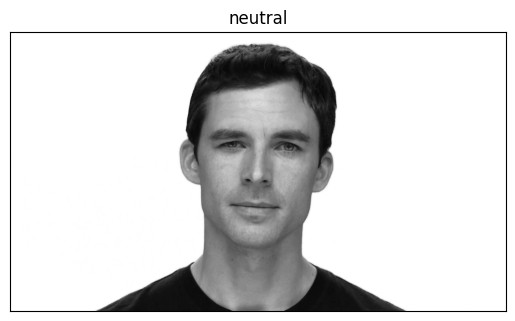

In [164]:
temp_video_path = download_video_from_gcs('audio_visual_data', 'data/visual_data/Actor_01/02-01-01-01-01-01-01.mp4')
cap = cv2.VideoCapture(temp_video_path)

# Set the frame index
cap.set(cv2.CAP_PROP_POS_FRAMES, 10)

# Read the frame
ret, frame = cap.read()
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Display the frame
plt.imshow(255 - gray_frame, cmap='Greys', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
plt.title(df[df['path_video'] == 'data/visual_data/Actor_01/02-01-01-01-01-01-01.mp4']['label'].values[0])
plt.savefig('visual_frame.png')
plt.show()


In [14]:
df[df['label'] == 'calm'].sample(1)

,label,path_video,path_audio
127,calm,data/visual_data/Actor_03/02-01-02-01-02-02-03...,data/audio_data/Actor_03/03-01-02-01-02-02-03.wav


In [162]:
def wav_plot(path):
    path_temp = download_video_from_gcs('audio_visual_data', path)
    wav, sample_rate = librosa.load(path_temp)
    
    # Invert the waveform by subtracting from the maximum amplitude (or flipping the signal)
    inverted_wav = -wav
    
    plt.figure(figsize=(12, 5))
    
    # Plot the inverted waveform
    librosa.display.waveshow(inverted_wav, sr=sample_rate, color='black')
    plt.gca().set_facecolor('white')  # Set background to black
    
    # Add title with inverted colors
    plt.title('Emotion: ' + df[df['path_audio'] == path]['label'].values[0], color='white')
    
    plt.savefig('audio_wav.png')
    # Show the plot
    plt.show()

def spectrogram_plot(path):
    path_temp = download_video_from_gcs('audio_visual_data', path)
    wav, sample_rate = librosa.load(path_temp)
    
    # Generate the spectrogram
    S = librosa.stft(y=wav)
    Xdb = librosa.amplitude_to_db(np.abs(S))
    
    plt.figure(figsize=(12, 3))
    
    # Set inverted colormap (using `cmap='gray_r'` to reverse gray colors)
    plt.title('Spectrogram for audio with {} emotion'.format(df[df['path_audio'] == path]['label'].values[0]), size=15, color='white')
    librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz', cmap='gray_r')
    
    # Colorbar for the spectrogram
    cbar = plt.colorbar()
    cbar.set_label('Amplitude (dB)', color='white')
    
    # Set the background and axis colors to inverted (black background)
    plt.gca().set_facecolor('black')
    

    plt.savefig('spectrogram.png', facecolor='white', edgecolor='black', bbox_inches='tight', pad_inches=0.2)  # Adjust pad_inches

    plt.show()

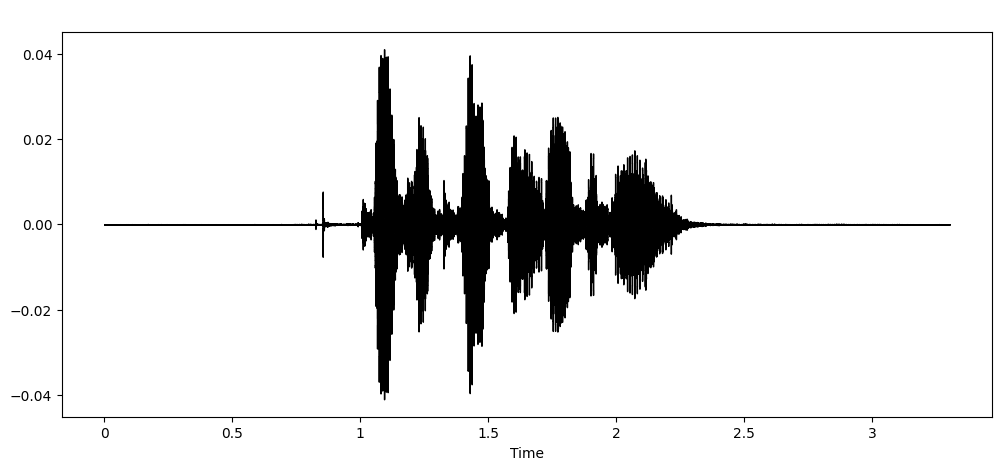

In [158]:
wav_plot('data/audio_data/Actor_01/03-01-01-01-01-01-01.wav')

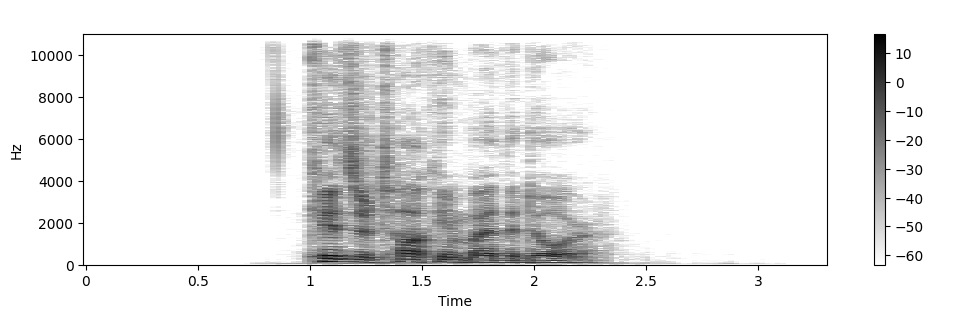

In [163]:
spectrogram_plot('data/audio_data/Actor_01/03-01-01-01-01-01-01.wav')

## Audio feature extractor

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [18]:
def preprocess_audio_mfcc(file_path, duration=2.5, sampling_rate=22050, n_mfcc=40):
    # Load the audio file
    path_temp = download_video_from_gcs('audio_visual_data', file_path)
    try:
        y, sr = librosa.load(path_temp, sr=sampling_rate, duration=duration, offset=0.5, res_type='kaiser_fast')

        if len(y) < duration * sr:
            y = np.pad(y, (0, max(0, int(duration * sr) - len(y))), "constant") # Ensuring that size of the extracted waveforms are the same
        
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc) # Extracting MFCC features
        

        return mfccs
    finally:
        os.remove(path_temp)


(40, 108)

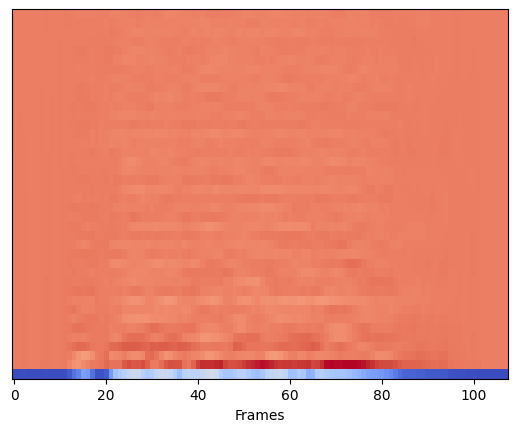

In [19]:
librosa.display.specshow(preprocess_audio_mfcc('data/audio_data/Actor_01/03-01-01-01-01-02-01.wav'), x_axis='frames')
preprocess_audio_mfcc('data/audio_data/Actor_01/03-01-01-01-01-02-01.wav').shape

## Video feature extractor

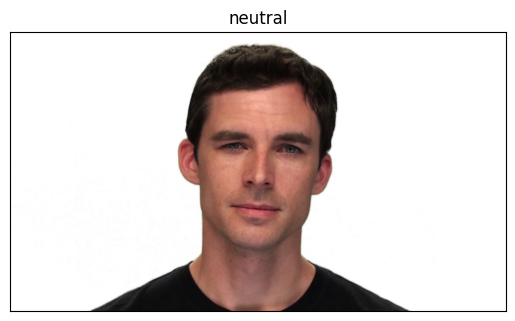

In [20]:
path_temp = download_video_from_gcs('audio_visual_data', 'data/visual_data/Actor_01/01-01-01-01-01-02-01.mp4')
vid_example = cv2.VideoCapture(path_temp)

ret, frames = vid_example.read()

plt.imshow(frames[:,:,::-1])
plt.xticks([])
plt.yticks([])
plt.title(df[df['path_video'] == 'data/visual_data/Actor_01/02-01-01-01-01-02-01.mp4']['label'].values[0])
plt.show()


Extracting 2.5 seconds of videos like in the audio files

In [21]:
import cv2

def read_video_emotion(video_path, target_size = (64, 64), num_frames = 10):
    
    path_temp = download_video_from_gcs('audio_visual_data', video_path)
    cap = cv2.VideoCapture(path_temp)
    
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break  
        resized_frame = cv2.resize(frame, target_size)
        frames.append(resized_frame)
        
    while len(frames) < num_frames:
        frames.append(np.zeros_like(frames[0]))
        
    cap.release()
    
    
    return np.array(frames)


video_path = 'data/visual_data/Actor_03/01-01-01-01-01-01-03.mp4'
frames_video = read_video_emotion(video_path)

print(f"Extracted {len(frames_video)} frames.")

Extracted 10 frames.


## Mapping

### Audio data

#### Preprocessing audio files

In [22]:
mfccs = []
for i in df['path_audio']:
    mfccs.append(preprocess_audio_mfcc(i))

In [23]:
mfccs = np.array(mfccs)
mfccs

array([[[-8.60149231e+02, -8.60149231e+02, -8.60149231e+02, ...,
         -8.59102173e+02, -8.58665161e+02, -8.58508057e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.47921848e+00,  2.09655309e+00,  2.31770730e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.47472215e+00,  2.08953214e+00,  2.30776119e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.45567465e-02, -1.06077746e-01, -4.08571303e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.11312103e-02, -1.79993212e-01, -4.80207592e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.46832496e-01, -2.51905710e-01, -5.47885776e-01]],

       [[-8.54144043e+02, -8.52475647e+02, -8.51339294e+02, ...,
         -8.55800293e+02, -8.55800293e+02, -8.55800293e+02],
        [ 2.33836555e+00,  4.69034195e+00,  6.27938557e+00, ...,
          0.00000000e+00,  0.00000000e

### Video data

#### Preprocessing video files

In [24]:
video_frames = []
 
for i in df['path_video']:
    video_frames.append(read_video_emotion(i))
video_frames = np.array(video_frames)

### Normalization

In [25]:
from sklearn.preprocessing import StandardScaler

mfcc_flattened = np.array([x.flatten() for x in mfccs])

scaler = StandardScaler()
scaler.fit(mfcc_flattened)
mfcc_scaled = scaler.fit_transform(mfcc_flattened)
original_shape = mfccs[0].shape  # Get the original shape from the first item
mfcc_scaled_reshaped = np.array([arr.reshape(original_shape) for arr in mfcc_scaled])
mfcc_scaled_reshaped = np.expand_dims(mfcc_scaled_reshaped, axis = 3)

mfcc_scaled_reshaped.shape

(1440, 40, 108, 1)

In [26]:
video_frames_flattened = np.array([i.flatten() for i in video_frames])

video_frames_scaled = video_frames_flattened / 255.0
original_shape_vid = video_frames[0].shape

video_frames_reshaped = np.array([arr.reshape(original_shape_vid) for arr in video_frames_scaled])

video_frames_reshaped.shape

(1440, 10, 64, 64, 3)

In [27]:
labels = df['label']
labels

0         neutral
1         neutral
2         neutral
3         neutral
4            calm
          ...    
1435    surprised
1436    surprised
1437    surprised
1438    surprised
1439    surprised
Name: label, Length: 1440, dtype: object

In [28]:
labels_mapper = {emo:i for i, emo in enumerate(emotion_dict.values())}
labels_mapper

{'neutral': 0,
 'calm': 1,
 'happy': 2,
 'sad': 3,
 'angry': 4,
 'fearful': 5,
 'disgust': 6,
 'surprised': 7}

In [29]:
labels = labels.map(labels_mapper)
labels

0       0
1       0
2       0
3       0
4       1
       ..
1435    7
1436    7
1437    7
1438    7
1439    7
Name: label, Length: 1440, dtype: int64

In [30]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Preparing dataset

### Whole dataset was first splitted into train and test sets, thus all models were trained on the same training set and tested on the same test set.

In [31]:
total_samples = len(labels)
train_size = int(total_samples * 0.7)

In [32]:
audio_dataset_tf = tf.data.Dataset.from_tensor_slices(mfcc_scaled_reshaped)
video_dataset_tf = tf.data.Dataset.from_tensor_slices(video_frames_reshaped)
labels_tf = tf.data.Dataset.from_tensor_slices(Y)

In [33]:
tf.random.set_seed(42)

combined_dataset = tf.data.Dataset.zip((audio_dataset_tf, video_dataset_tf), labels_tf)
combined_dataset_shuffled = combined_dataset.shuffle(buffer_size=total_samples, seed= 42, reshuffle_each_iteration = False) 

In [34]:
combined_dataset_cached = combined_dataset_shuffled.cache()

In [35]:
train_data = combined_dataset_cached.take(train_size)
train_data = train_data.batch(8)
train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)

In [36]:
val_data = combined_dataset_cached.skip(train_size)
val_data = val_data.batch(8)
val_data = val_data.prefetch(buffer_size = tf.data.AUTOTUNE)

2 functions below are needed to extract only necessary data for unimodal models (audio or visual modalities)

In [37]:
def extract_audio_data(data): 
    def select_audio_label(elements, label):
        (audio, video) = elements
        return audio, label  
    # Map this function across the dataset
    return data.map(select_audio_label)

In [38]:
def extract_video_data(data): 
    def select_audio_label(elements, label):
        (audio, video) = elements
        return video, label  
    # Map this function across the dataset
    return data.map(select_audio_label)

## Data for audio models

In [39]:
train_onlyaudio = extract_audio_data(train_data)
val_onlyaudio = extract_audio_data(val_data)

## Data for video model

In [40]:
train_onlyvideo = extract_video_data(train_data)
val_onlyvideo = extract_video_data(val_data)

# Audio emotion recognition

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dropout
from keras_self_attention import SeqSelfAttention
# Define input shape. Assume MFCC feature extraction results in 40 coefficients over 108 frames
input_shape = (40, 108, 1)  # 100 time steps, 40 MFCC features, 1 channel

# Input layer
input_layer = Input(shape=input_shape)

# First CNN block
conv1 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
act1 = Activation('relu')(batch_norm1)
pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
dropout1 = Dropout(rate = 0.2)(pool1)

# Second CNN block
conv2 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(pool1)
batch_norm2 = BatchNormalization()(conv2)
act2 = Activation('relu')(batch_norm2)
pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
dropout2 = Dropout(rate = 0.2)(pool2)

# Third CNN block
conv3 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(pool2)
batch_norm3 = BatchNormalization()(conv3)
act3 = Activation('relu')(batch_norm3)
pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
dropout3 = Dropout(rate = 0.2)(pool3)


# Reshape for LSTM layer - Assuming the output is sequenced for LSTM processing
reshaped_for_lstm = Reshape((-1, 64))(dropout3)  

# LSTM layer
lstm_1 = LSTM(64, return_sequences=True)(reshaped_for_lstm)

# # Attention mechanism
attention = SeqSelfAttention(attention_activation='tanh')(lstm_1)


lstm_2 = LSTM(64, return_sequences=False)(attention)

# Dense layer for classification
output = Dense(8, activation = 'softmax')(lstm_2)

audio_model = Model(inputs=input_layer, outputs=output)


audio_model.summary()

/home/muhambettulegenov01/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 108, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 40, 108, 64)       640       
                                                                 
 batch_normalization (Batch  (None, 40, 108, 64)       256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40, 108, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 54, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 54, 128)       73856 

In [42]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)
audio_model.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
# Setting up the EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss',       
                                        patience=10,           
                                        verbose=1,
                                        restore_best_weights=True
                                        
                                        )
history = audio_model.fit(train_onlyaudio,
                          epochs=100,
                          callbacks=[early_stopping_callback],
                          validation_data=val_onlyaudio
                         )

Epoch 1/100
107/126 [========================>.....] - ETA: 5s - loss: 2.0201 - accuracy: 0.1706

2024-09-12 17:23:34.332787: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


126/126 [==============================] - 50s 355ms/step - loss: 2.0080 - accuracy: 0.1877 - val_loss: 2.0792 - val_accuracy: 0.1455
Epoch 2/100
126/126 [==============================] - 40s 314ms/step - loss: 1.8058 - accuracy: 0.3227 - val_loss: 2.1047 - val_accuracy: 0.1709
Epoch 3/100
126/126 [==============================] - 40s 314ms/step - loss: 1.5923 - accuracy: 0.3952 - val_loss: 2.0297 - val_accuracy: 0.2125
Epoch 4/100
126/126 [==============================] - 40s 315ms/step - loss: 1.4163 - accuracy: 0.4767 - val_loss: 1.8193 - val_accuracy: 0.3303
Epoch 5/100
126/126 [==============================] - 40s 318ms/step - loss: 1.3381 - accuracy: 0.5104 - val_loss: 1.6856 - val_accuracy: 0.3326
Epoch 6/100
126/126 [==============================] - 41s 325ms/step - loss: 1.2588 - accuracy: 0.5422 - val_loss: 1.3481 - val_accuracy: 0.5266
Epoch 7/100
126/126 [==============================] - 40s 320ms/step - loss: 1.2021 - accuracy: 0.5650 - val_loss: 1.8391 - val_accurac

In [43]:
print('Test accuracy: ', audio_model.evaluate(val_onlyaudio, verbose=0)[1])

Test accuracy:  0.5866050720214844


# Visual emotion recognition

In [44]:
from tensorflow.keras.layers import Input, ConvLSTM3D, Flatten, Dense, LSTM, concatenate, TimeDistributed, Conv3D, MaxPooling3D

input_shape = (10, 64, 64, 3) # 10 frames, image size - (64, 64), 3 channels (RGB)

def build_video_model_1(input_shape):
    input_layer = Input(shape = input_shape)

    
    conv_1 = Conv3D(filters=32, kernel_size=3, activation='relu')(input_layer)
    batch_norm1 = BatchNormalization()(conv_1)
    activation1 = Activation('relu')(batch_norm1)
    max_pool1 = MaxPooling3D()(activation1)

    
    
    conv_2 = Conv3D(filters=64, kernel_size=3, activation='relu')(max_pool1)
    batch_norm1 = BatchNormalization()(conv_2)
    activation2 = Activation('relu')(batch_norm1)
    max_pool2 = MaxPooling3D()(activation2)

    
    flat = Flatten()(max_pool2)

    dense_1 = Dense(512, activation='relu')(flat)
    dense_2 = Dense(256, activation='relu')(dense_1)
    dense_3 = Dense(128, activation='relu')(dense_2)
    
    dropout = Dropout(0.2)(dense_3)
    classifier = Dense(8, activation='softmax')(dropout)
    video_model = Model(inputs = input_layer, outputs = classifier)
    
    return video_model

video_model = build_video_model_1(input_shape)
video_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 8, 62, 62, 32)     2624      
                                                                 
 batch_normalization_3 (Bat  (None, 8, 62, 62, 32)     128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 8, 62, 62, 32)     0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 4, 31, 31, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 29, 29, 64)     5536

In [45]:
from tensorflow.keras.optimizers import Adam

tf.keras.utils.set_random_seed(42)
video_model.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_video = video_model.fit(train_onlyvideo,
                          epochs=100,
                          callbacks=[early_stopping_callback],
                          validation_data=val_onlyvideo)

Epoch 1/100
126/126 [==============================] - 75s 587ms/step - loss: 2.3266 - accuracy: 0.1490 - val_loss: 2.0780 - val_accuracy: 0.1293
Epoch 2/100
126/126 [==============================] - 72s 569ms/step - loss: 1.9814 - accuracy: 0.2145 - val_loss: 2.0721 - val_accuracy: 0.1709
Epoch 3/100
126/126 [==============================] - 73s 575ms/step - loss: 1.7720 - accuracy: 0.3138 - val_loss: 2.0266 - val_accuracy: 0.2125
Epoch 4/100
126/126 [==============================] - 72s 572ms/step - loss: 1.4941 - accuracy: 0.4409 - val_loss: 1.8989 - val_accuracy: 0.2818
Epoch 5/100
126/126 [==============================] - 72s 573ms/step - loss: 1.1557 - accuracy: 0.5909 - val_loss: 1.7460 - val_accuracy: 0.3464
Epoch 6/100
126/126 [==============================] - 72s 573ms/step - loss: 0.8248 - accuracy: 0.7051 - val_loss: 1.6595 - val_accuracy: 0.3718
Epoch 7/100
126/126 [==============================] - 72s 573ms/step - loss: 0.5708 - accuracy: 0.8183 - val_loss: 1.6954 -

In [46]:
print('Accuracy:', video_model.evaluate(val_onlyvideo))

55/55 [==============================] - 2s 39ms/step - loss: 1.5603 - accuracy: 0.5497
Accuracy: [1.5602905750274658, 0.5496535897254944]


# Audio-visual emotion recognition

In [47]:
def build_video_subnetwork(input_shape = (10, 64, 64, 3)):
    input_layer = Input(shape = input_shape)

    
    conv_1 = Conv3D(filters=32, kernel_size=3, activation='relu')(input_layer)
    batch_norm1 = BatchNormalization()(conv_1)
    activation1 = Activation('relu')(batch_norm1)
    max_pool1 = MaxPooling3D()(activation1)

    
    conv_2 = Conv3D(filters=64, kernel_size=3, activation='relu')(max_pool1)
    batch_norm1 = BatchNormalization()(conv_2)
    activation2 = Activation('relu')(batch_norm1)
    max_pool2 = MaxPooling3D()(activation2)

    
    flat = Flatten()(max_pool2)

    dense_1 = Dense(512, activation='relu')(flat)
    dense_2 = Dense(256, activation='relu')(dense_1)
    dense_3 = Dense(128, activation='relu')(dense_2)
    
    dropout = Dropout(0.2)(dense_3)
    video_model = Model(inputs = input_layer, outputs = dropout)
    
    return video_model

video_subnetwork = build_video_subnetwork()
video_subnetwork.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 62, 62, 32)     2624      
                                                                 
 batch_normalization_5 (Bat  (None, 8, 62, 62, 32)     128       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 8, 62, 62, 32)     0         
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 4, 31, 31, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 29, 29, 64)     5536

In [48]:
def build_audio_subnetwork():
    input_shape = (40, 108,1)  # 100 time steps, 40 MFCC features, 1 channel

    # Input layer
    input_layer = Input(shape=input_shape)

    # First CNN block
    conv1 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch_norm1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
    dropout1 = Dropout(rate = 0.5)(pool1)

    # Second CNN block
    conv2 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(pool1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(batch_norm2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    dropout2 = Dropout(rate = 0.5)(pool2)


    conv3 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(pool2)
    batch_norm3 = BatchNormalization()(conv3)
    act3 = Activation('relu')(batch_norm3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
    dropout3 = Dropout(rate = 0.5)(pool3)


    # # # Reshape for LSTM layer - Assuming the output is sequenced for LSTM processing
    reshaped_for_lstm = Reshape((-1, 64))(dropout3)  # Example reshape, adjust based on your pooling and convolutional layers' output

    # # LSTM layer
    lstm_1 = LSTM(64, return_sequences=True)(reshaped_for_lstm)

    # # Attention mechanism
    attention = SeqSelfAttention(attention_activation='tanh')(lstm_1)

    # # Dense layer for classification
    lstm_2 = LSTM(64, return_sequences=False)(attention)
    
    dense_final = Dense(128)(lstm_2)
    audio_model = Model(inputs=input_layer, outputs=dense_final)
    
    return audio_model

audio_subnetwork = build_audio_subnetwork()
audio_subnetwork.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40, 108, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 108, 64)       640       
                                                                 
 batch_normalization_7 (Bat  (None, 40, 108, 64)       256       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 40, 108, 64)       0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 20, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 54, 128)       7385

In [49]:
from tensorflow.keras.layers import Concatenate
audio_subnetwork_output = audio_subnetwork.output
video_subnetwork_output = video_subnetwork.output

# Concatenate the outputs
concatenated = Concatenate()([audio_subnetwork_output, video_subnetwork_output])

# Add any additional layers after the concatenation
# For example, you can add a Dense layer or any specific task-oriented layer
dense_1 = Dense(128, activation='relu')(concatenated)
dense_2 = Dense(64, activation='relu')(dense_1)
dense_final = Dense(8, activation='softmax')(dense_2)

# Define the final model
final_model = Model(inputs=[audio_subnetwork.input, video_subnetwork.input], outputs=dense_final)
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 40, 108, 1)]         0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 40, 108, 64)          640       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 40, 108, 64)          256       ['conv2d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_7 (Activation)   (None, 40, 108, 64)          0         ['batch_normalization_7[

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)
final_model.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_final = final_model.fit(train_data,
                          epochs=100,
                          callbacks=[early_stopping_callback],
                          validation_data=val_data)

Epoch 1/100
126/126 [==============================] - 100s 736ms/step - loss: 2.1566 - accuracy: 0.1341 - val_loss: 2.0776 - val_accuracy: 0.1617
Epoch 2/100
126/126 [==============================] - 91s 719ms/step - loss: 2.0501 - accuracy: 0.1847 - val_loss: 2.0760 - val_accuracy: 0.1594
Epoch 3/100
126/126 [==============================] - 90s 713ms/step - loss: 1.8719 - accuracy: 0.2681 - val_loss: 2.2076 - val_accuracy: 0.1570
Epoch 4/100
126/126 [==============================] - 91s 720ms/step - loss: 1.5943 - accuracy: 0.3992 - val_loss: 2.5768 - val_accuracy: 0.1570
Epoch 5/100
126/126 [==============================] - 94s 748ms/step - loss: 1.3627 - accuracy: 0.5074 - val_loss: 2.0284 - val_accuracy: 0.2748
Epoch 6/100
126/126 [==============================] - 94s 749ms/step - loss: 1.0847 - accuracy: 0.6018 - val_loss: 1.6573 - val_accuracy: 0.4296
Epoch 7/100
126/126 [==============================] - 95s 753ms/step - loss: 0.7513 - accuracy: 0.7468 - val_loss: 1.3907 

In [51]:
final_model.evaluate(val_data)

55/55 [==============================] - 5s 95ms/step - loss: 1.1399 - accuracy: 0.6212


[1.139883041381836, 0.6212471127510071]

## Audio model without attention

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dropout
from keras_self_attention import SeqSelfAttention
# Define input shape. Assume MFCC feature extraction results in 40 coefficients over 100 frames
input_shape = (40, 108,1)  # 100 time steps, 40 MFCC features, 1 channel

# Input layer
input_layer = Input(shape=input_shape)

# First CNN block
conv1 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
act1 = Activation('relu')(batch_norm1)
pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
dropout1 = Dropout(rate = 0.2)(pool1)

# Second CNN block
conv2 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(pool1)
batch_norm2 = BatchNormalization()(conv2)
act2 = Activation('relu')(batch_norm2)
pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
dropout2 = Dropout(rate = 0.2)(pool2)


conv3 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(pool2)
batch_norm3 = BatchNormalization()(conv3)
act3 = Activation('relu')(batch_norm3)
pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
dropout3 = Dropout(rate = 0.2)(pool3)


# # # Reshape for LSTM layer - Assuming the output is sequenced for LSTM processing
reshaped_for_lstm = Reshape((-1, 64))(dropout3)  # Example reshape, adjust based on your pooling and convolutional layers' output

# # LSTM layer
lstm_1 = LSTM(64, return_sequences=False)(reshaped_for_lstm)



output = Dense(8, activation = 'softmax')(lstm_1)

audio_model_without_att = Model(inputs=input_layer, outputs=output)


audio_model_without_att.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40, 108, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 108, 64)       640       
                                                                 
 batch_normalization_10 (Ba  (None, 40, 108, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 40, 108, 64)       0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 20, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 54, 128)       7385

In [53]:
from tensorflow.keras.optimizers import Adam

tf.keras.utils.set_random_seed(42)

audio_model_without_att.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss',       
                                        patience=10,           
                                        verbose=1
                                        
                                        )
history_audio_without_attention = audio_model_without_att.fit(train_onlyaudio,
                          epochs=100,
                          callbacks=[early_stopping_callback],
                          validation_data=val_onlyaudio)

Epoch 1/100
126/126 [==============================] - 19s 125ms/step - loss: 2.0169 - accuracy: 0.2155 - val_loss: 2.0734 - val_accuracy: 0.1640
Epoch 2/100
126/126 [==============================] - 15s 120ms/step - loss: 1.8255 - accuracy: 0.3376 - val_loss: 2.0448 - val_accuracy: 0.1986
Epoch 3/100
126/126 [==============================] - 15s 119ms/step - loss: 1.6844 - accuracy: 0.4359 - val_loss: 1.9302 - val_accuracy: 0.2748
Epoch 4/100
126/126 [==============================] - 15s 119ms/step - loss: 1.5155 - accuracy: 0.5094 - val_loss: 1.7679 - val_accuracy: 0.3741
Epoch 5/100
126/126 [==============================] - 15s 118ms/step - loss: 1.3221 - accuracy: 0.6197 - val_loss: 1.6770 - val_accuracy: 0.3857
Epoch 6/100
126/126 [==============================] - 15s 119ms/step - loss: 1.1235 - accuracy: 0.7051 - val_loss: 1.7088 - val_accuracy: 0.3487
Epoch 7/100
126/126 [==============================] - 15s 118ms/step - loss: 0.9434 - accuracy: 0.7587 - val_loss: 1.6840 -

In [54]:
audio_model_without_att.evaluate(val_onlyaudio)

55/55 [==============================] - 1s 25ms/step - loss: 1.9118 - accuracy: 0.3857


[1.9118105173110962, 0.38568130135536194]

# Video model attention + CNN + LSTM

In [55]:
input_shape = (10, 64, 64, 3) # 10 frames, image size - (64, 64), 3 channels (RGB)

def build_video_model_attention(input_shape):
    input_layer = Input(shape = input_shape)

    
    conv_1 = Conv3D(filters=32, kernel_size=3, activation='relu')(input_layer)
    batch_norm1 = BatchNormalization()(conv_1)
    activation1 = Activation('relu')(batch_norm1)
    max_pool1 = MaxPooling3D()(activation1)

    
    
    conv_2 = Conv3D(filters=64, kernel_size=3, activation='relu')(max_pool1)
    batch_norm1 = BatchNormalization()(conv_2)
    activation2 = Activation('relu')(batch_norm1)
    max_pool2 = MaxPooling3D()(activation2)

    reshaped = TimeDistributed(Flatten())(max_pool2)
    
    # LSTM Layer
    lstm_out = LSTM(128, return_sequences=True)(reshaped)
    
    # Self-Attention
    attention_out = SeqSelfAttention(attention_activation='tanh')(lstm_out)
    
    pooled_out = tf.keras.layers.GlobalAveragePooling1D()(attention_out)
    
    # Dense Layers
    dense_1 = Dense(512, activation='relu')(pooled_out)
    dense_2 = Dense(256, activation='relu')(dense_1)
    dense_3 = Dense(128, activation='relu')(dense_2)
    
    dropout = Dropout(0.2)(dense_3)
    classifier = Dense(8, activation='softmax')(dropout)
    
    video_model = Model(inputs=input_layer, outputs=classifier)
    
    return video_model
    
video_model_attention = build_video_model_attention(input_shape)
video_model_attention.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 8, 62, 62, 32)     2624      
                                                                 
 batch_normalization_13 (Ba  (None, 8, 62, 62, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (None, 8, 62, 62, 32)     0         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 4, 31, 31, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 29, 29, 64)     5536

In [56]:
tf.keras.utils.set_random_seed(42)
video_model_attention.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_video_model_attention = video_model_attention.fit(train_onlyvideo,
                          epochs=100,
                          callbacks=[early_stopping_callback],
                          validation_data=val_onlyvideo)

Epoch 1/100
126/126 [==============================] - 78s 584ms/step - loss: 2.0709 - accuracy: 0.1341 - val_loss: 2.0751 - val_accuracy: 0.1224
Epoch 2/100
126/126 [==============================] - 73s 578ms/step - loss: 2.0512 - accuracy: 0.1648 - val_loss: 2.0696 - val_accuracy: 0.1478
Epoch 3/100
126/126 [==============================] - 73s 578ms/step - loss: 2.0040 - accuracy: 0.1787 - val_loss: 2.0480 - val_accuracy: 0.1686
Epoch 4/100
126/126 [==============================] - 73s 576ms/step - loss: 1.9033 - accuracy: 0.2751 - val_loss: 1.9860 - val_accuracy: 0.1501
Epoch 5/100
126/126 [==============================] - 73s 577ms/step - loss: 1.7128 - accuracy: 0.3635 - val_loss: 1.8734 - val_accuracy: 0.2240
Epoch 6/100
126/126 [==============================] - 73s 578ms/step - loss: 1.4669 - accuracy: 0.4677 - val_loss: 1.7593 - val_accuracy: 0.3002
Epoch 7/100
126/126 [==============================] - 73s 578ms/step - loss: 1.2182 - accuracy: 0.5760 - val_loss: 1.7421 -

## Audio-visual model

In [62]:
def build_video_attention_subnetwork(input_shape = (10, 64, 64, 3)):
    input_layer = Input(shape = input_shape)

    
    conv_1 = Conv3D(filters=32, kernel_size=3, activation='relu')(input_layer)
    batch_norm1 = BatchNormalization()(conv_1)
    activation1 = Activation('relu')(batch_norm1)
    max_pool1 = MaxPooling3D()(activation1)

    
    
    conv_2 = Conv3D(filters=64, kernel_size=3, activation='relu')(max_pool1)
    batch_norm1 = BatchNormalization()(conv_2)
    activation2 = Activation('relu')(batch_norm1)
    max_pool2 = MaxPooling3D()(activation2)

    reshaped = TimeDistributed(Flatten())(max_pool2)
    
    # LSTM Layer
    lstm_out = LSTM(128, return_sequences=True)(reshaped)
    
    # Self-Attention
    attention_out = SeqSelfAttention(attention_activation='tanh')(lstm_out)

    pooled_out = tf.keras.layers.GlobalAveragePooling1D()(attention_out)

    # Dense Layers
    dense_1 = Dense(512, activation='relu')(pooled_out)
    dense_2 = Dense(256, activation='relu')(dense_1)
    dense_3 = Dense(128, activation='relu')(dense_2)
    
    dropout = Dropout(0.2)(dense_3)
    
    video_model = Model(inputs = input_layer, outputs = dropout)
    
    return video_model

video_subnetwork_attention = build_video_attention_subnetwork()
video_subnetwork_attention.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d_10 (Conv3D)          (None, 8, 62, 62, 32)     2624      
                                                                 
 batch_normalization_22 (Ba  (None, 8, 62, 62, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_22 (Activation)  (None, 8, 62, 62, 32)     0         
                                                                 
 max_pooling3d_10 (MaxPooli  (None, 4, 31, 31, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_11 (Conv3D)          (None, 2, 29, 29, 64)     553

In [58]:
def build_audio_subnetwork():
    input_shape = (40, 108,1)  # 100 time steps, 40 MFCC features, 1 channel

    # Input layer
    input_layer = Input(shape=input_shape)

    # First CNN block
    conv1 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch_norm1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
    dropout1 = Dropout(rate = 0.2)(pool1)

    # Second CNN block
    conv2 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(pool1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(batch_norm2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    dropout2 = Dropout(rate = 0.2)(pool2)


    conv3 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(pool2)
    batch_norm3 = BatchNormalization()(conv3)
    act3 = Activation('relu')(batch_norm3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
    dropout3 = Dropout(rate = 0.2)(pool3)


    # # # Reshape for LSTM layer - Assuming the output is sequenced for LSTM processing
    reshaped_for_lstm = Reshape((-1, 64))(dropout3)  # Example reshape, adjust based on your pooling and convolutional layers' output

    # # LSTM layer
    lstm_1 = LSTM(64, return_sequences=True)(reshaped_for_lstm)

    # # Attention mechanism
    attention = SeqSelfAttention(attention_activation='tanh')(lstm_1)

    # # Dense layer for classification
    lstm_2 = LSTM(64, return_sequences=False)(attention)
    
    dense_final = Dense(128)(lstm_2)
    audio_model = Model(inputs=input_layer, outputs=dense_final)
    
    return audio_model

audio_subnetwork = build_audio_subnetwork()
audio_subnetwork.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 40, 108, 1)]      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 108, 64)       640       
                                                                 
 batch_normalization_17 (Ba  (None, 40, 108, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_17 (Activation)  (None, 40, 108, 64)       0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 20, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 54, 128)       7385

In [63]:
from tensorflow.keras.layers import Concatenate
audio_subnetwork_output = audio_subnetwork.output
video_subnetwork_attention_output = video_subnetwork_attention.output

# Concatenate the outputs
concatenated_attention = Concatenate()([audio_subnetwork_output, video_subnetwork_attention_output])

# Add any additional layers after the concatenation
# For example, you can add a Dense layer or any specific task-oriented layer
dense_1_attention = Dense(128, activation='relu')(concatenated_attention)
dense_2_attention = Dense(64, activation='relu')(dense_1_attention)
dense_final_attention = Dense(8, activation='softmax')(dense_2_attention)

# Define the final model
final_model_attention = Model(inputs=[audio_subnetwork.input, video_subnetwork_attention.input], outputs=dense_final_attention)
final_model_attention.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 40, 108, 1)]         0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 40, 108, 64)          640       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 40, 108, 64)          256       ['conv2d_9[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 input_10 (InputLayer)       [(None, 10, 64, 64, 3)]      0         []                     

In [64]:
tf.keras.utils.set_random_seed(42)
final_model_attention.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_final_attention = final_model_attention.fit(train_data,
                          epochs=100,
                          callbacks=[early_stopping_callback],
                          validation_data=val_data)

Epoch 1/100
126/126 [==============================] - 105s 750ms/step - loss: 2.0628 - accuracy: 0.1370 - val_loss: 2.0765 - val_accuracy: 0.1293
Epoch 2/100
126/126 [==============================] - 94s 745ms/step - loss: 1.9277 - accuracy: 0.2185 - val_loss: 2.1275 - val_accuracy: 0.1570
Epoch 3/100
126/126 [==============================] - 93s 741ms/step - loss: 1.7257 - accuracy: 0.3069 - val_loss: 2.3252 - val_accuracy: 0.1732
Epoch 4/100
126/126 [==============================] - 94s 742ms/step - loss: 1.5747 - accuracy: 0.3734 - val_loss: 1.8935 - val_accuracy: 0.3095
Epoch 5/100
126/126 [==============================] - 94s 742ms/step - loss: 1.4131 - accuracy: 0.4707 - val_loss: 1.6361 - val_accuracy: 0.4111
Epoch 6/100
126/126 [==============================] - 94s 750ms/step - loss: 1.1714 - accuracy: 0.5859 - val_loss: 1.4780 - val_accuracy: 0.4596
Epoch 7/100
126/126 [==============================] - 93s 742ms/step - loss: 0.9896 - accuracy: 0.6584 - val_loss: 1.3071 

# Evaluation of models

In [96]:
def plot_confusion_matrix(model, dataset, modality, class_names=emotion_dict.values()):

    y_true = []
    y_pred = []
    
    for batch in dataset:
        images, labels = batch
        preds = model.predict(images, verbose = 0)
        y_true.extend(np.argmax(labels.numpy(), axis = 1))
        y_pred.extend(np.argmax(preds, axis=1))

    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(class_names))
    
    cm_np = cm.numpy()
    cm = cm_np / cm_np.sum(axis=1)[:, np.newaxis]

    
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title=f'Confusion Matrix for {modality}',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(f'{modality}.png')

    plt.show()


## Confusion matrix for audio model with attention

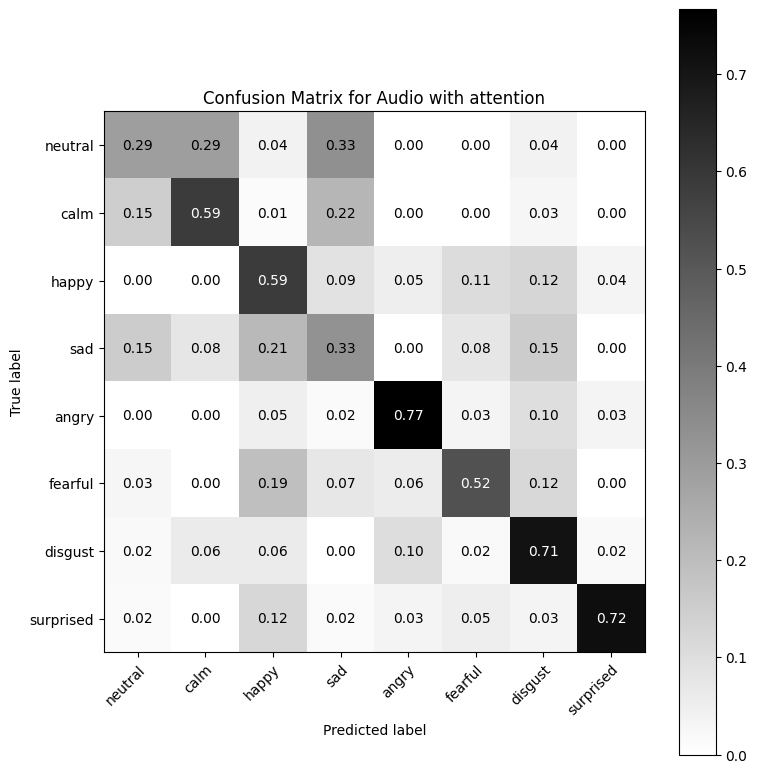

In [165]:
plot_confusion_matrix(audio_model, val_onlyaudio, 'Audio with attention')

## Confusion matrix for audio without attention

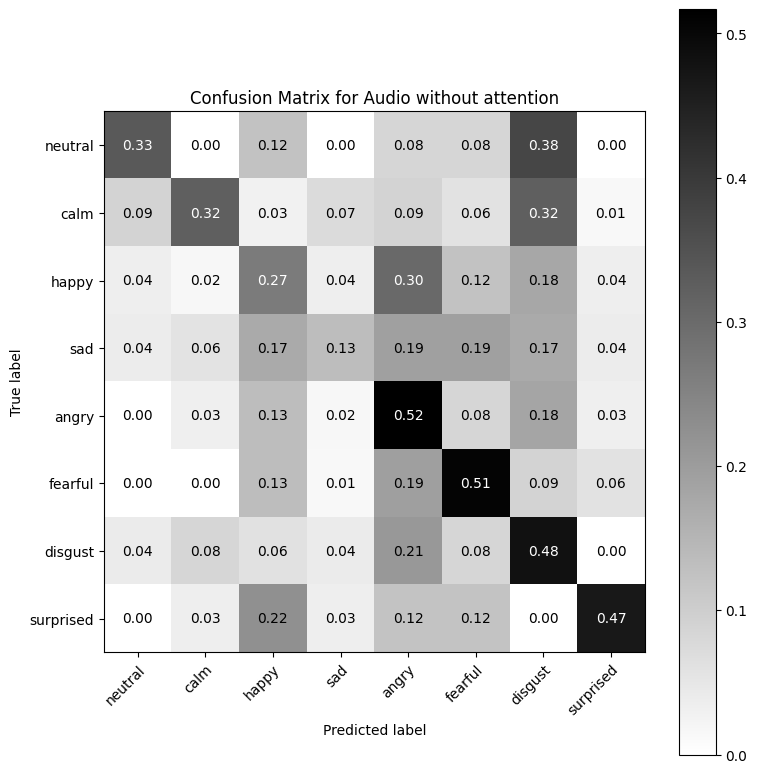

In [166]:
plot_confusion_matrix(audio_model_without_att, val_onlyaudio, 'Audio without attention')

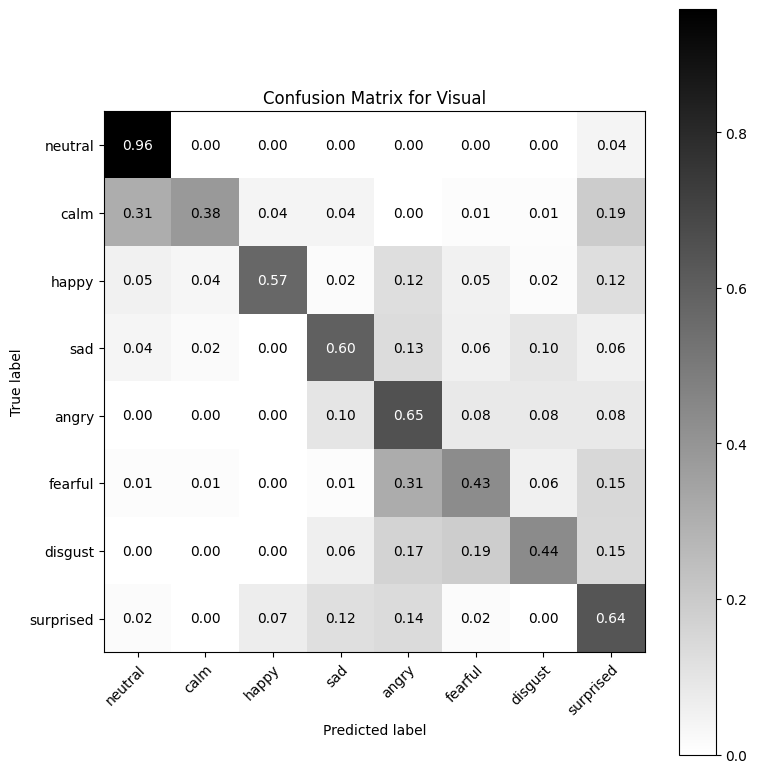

In [167]:
plot_confusion_matrix(video_model, val_onlyvideo, 'Visual')

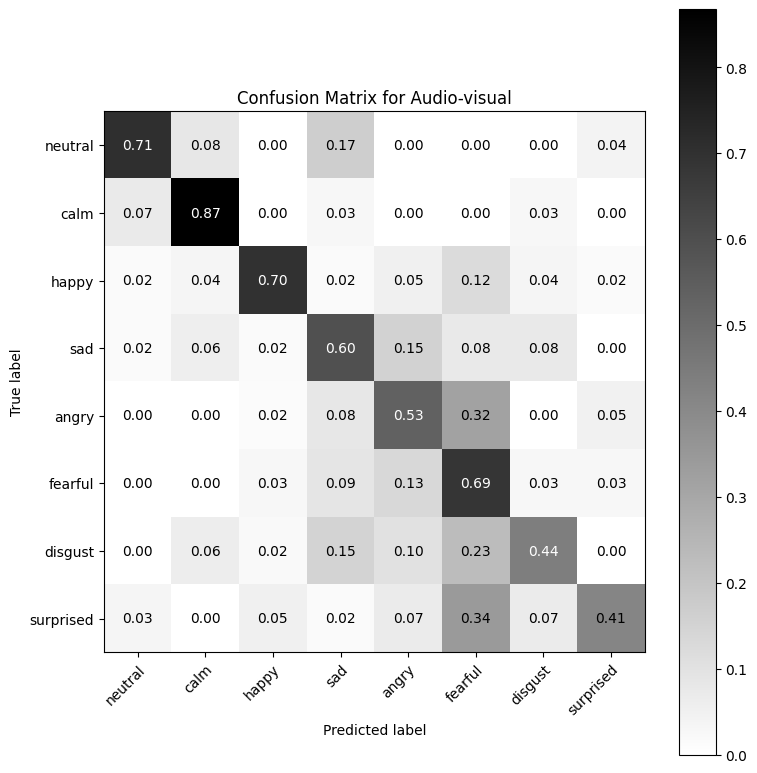

In [168]:
plot_confusion_matrix(final_model, val_data, 'Audio-visual')

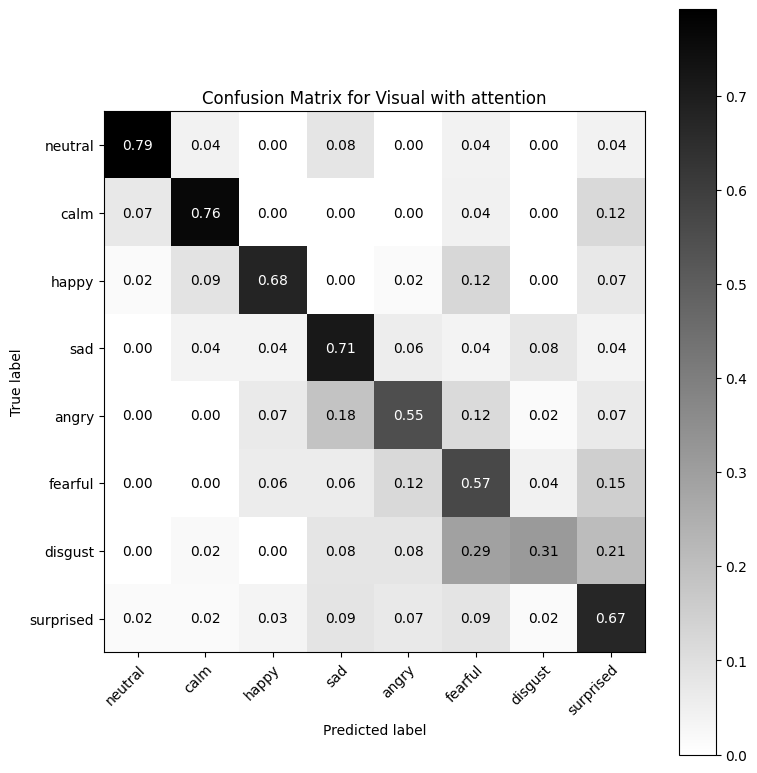

In [169]:
plot_confusion_matrix(video_model_attention, val_onlyvideo, 'Visual with attention')

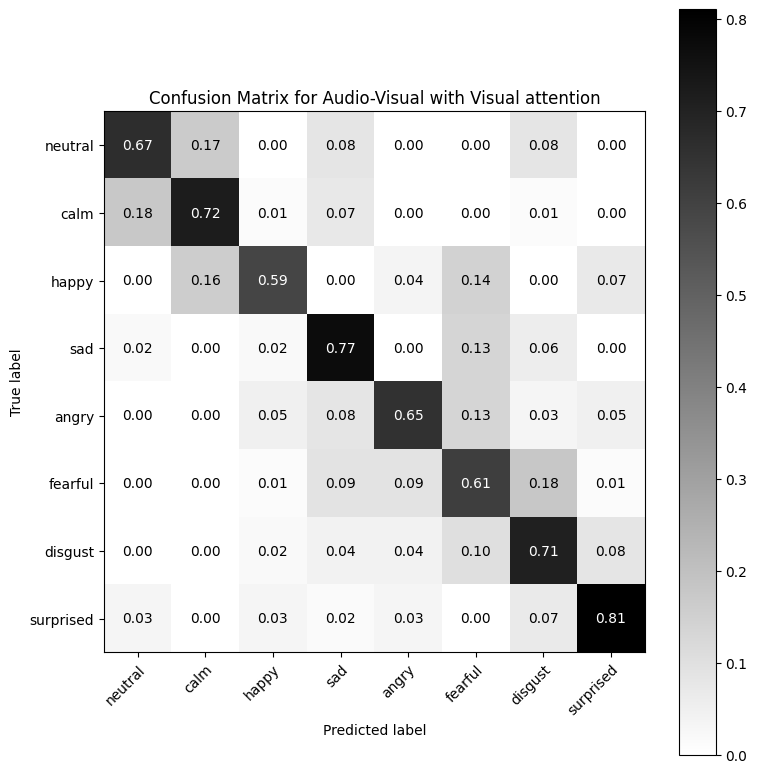

In [170]:
plot_confusion_matrix(final_model_attention, val_data, 'Audio-Visual with Visual attention')

# Precision and recall

In [72]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def performance_evaluate_model(model, test_set):
    all_predictions = []
    all_labels = []

    for inputs, labels in test_set:
        predictions = model.predict(inputs, verbose = 0)

        all_predictions.extend(np.argmax(predictions,axis=1))
        all_labels.extend(np.argmax(labels, axis = 1))

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro')

    return {
        "precision": precision,
        "recall": recall,
        "F1 score": f1_score,
        "Accuracy":accuracy
    }

In [73]:
print('Audio with attention: \n')
performance_evaluate_model(audio_model, val_onlyaudio)

Audio with attention: 



{'precision': 0.5767418323861453,
 'recall': 0.5647045928411351,
 'F1 score': 0.5635663284298472,
 'Accuracy': 0.5866050808314087}

In [74]:
print('Audio without attention: \n')
performance_evaluate_model(audio_model_without_att, val_onlyaudio)

Audio without attention: 



{'precision': 0.4242182837587012,
 'recall': 0.3785185667312968,
 'F1 score': 0.37783427021494065,
 'Accuracy': 0.3856812933025404}

In [75]:
print('Video model: \n')
performance_evaluate_model(video_model, val_onlyvideo)

Video model: 



{'precision': 0.5937031512377012,
 'recall': 0.5833169434338128,
 'F1 score': 0.555531175091819,
 'Accuracy': 0.5496535796766744}

In [76]:
print('Audio-visual model: \n')
performance_evaluate_model(final_model, val_data)

Audio-visual model: 



{'precision': 0.6514069693946535,
 'recall': 0.6174695513374993,
 'F1 score': 0.6213017440701911,
 'Accuracy': 0.6212471131639723}

In [88]:
print('Video model with attention: \n')
performance_evaluate_model(video_model_attention, val_onlyvideo)

Video model with attention: 



{'precision': 0.6447410623038285,
 'recall': 0.631070051417178,
 'F1 score': 0.6278130057017955,
 'Accuracy': 0.625866050808314}

In [86]:
print('Audio-visual model with video attention: \n')
performance_evaluate_model(final_model_attention, val_data)

Audio-visual model with video attention: 



{'precision': 0.6862036813103074,
 'recall': 0.6907987306130339,
 'F1 score': 0.6834588052179634,
 'Accuracy': 0.6905311778290993}